In [70]:
import torch
import random
import numpy as np
import selfies as sf
import networkx as nx
import torch_geometric
import group_selfies as gs
import torch.nn.functional as F

from rdkit import Chem
from copy import deepcopy
from dockstring import load_target
from global_chem import GlobalChem
from IPython.display import display
from collections import OrderedDict
from rdkit.Chem import Descriptors, Draw
from pathos.multiprocessing import ProcessingPool as Pool
from torch_geometric.utils.convert import to_networkx, from_networkx

In [71]:
class GroupSelfies_Molecule_Env:
    
    def __init__(self, grammar=None, action_size=100, dockstring_target='DRD2', episode_length=10):
        
        # Creat dockstring target
        self.dockstring_target = load_target(dockstring_target)

        # Create Molecular Action Space
        self.create_molecular_action_space(grammar=grammar, action_size=action_size)
        
        # Set Episode Length
        self.episode_length = episode_length

        self.reset()

    def create_molecular_action_space(self, grammar=None, action_size=100):

        self.grammar = grammar if grammar is not None else gs.group_grammar.common_r_group_replacements_grammar()
        
        group_selfies_strs = []
        for name, group in self.grammar.vocab.items():
            smiles = Chem.MolToSmiles(group.mol_without_attachment_points())
            group_selfies_strs.append(self.grammar.full_encoder(Chem.MolFromSmiles(smiles)))

        self.action_space = random.sample(group_selfies_strs, action_size)

    def reset(self):
        
        # Initialize Molecule
        self.molecule = None

        # Initialize Step
        self.num_step = 0

    def evaluate_dockstring(self, ligand_smiles):

        score, aux = self.dockstring_target.dock(ligand_smiles)

        return score, aux

    def get_gs_state(self):
        return self.grammar.decoder(self.molecule)
    
    def step(self, action, calc_dockstring=False):
        
        group_sf_string = self.action_space[action]

        if self.molecule is None:
            self.molecule = group_sf_string
        else:
            self.molecule = self.molecule + group_sf_string

        if self.num_step < self.episode_length and calc_dockstring is False:
            self.num_step += 1
            reward = 0; done = False; info = {}
            return self.molecule, reward, done, info
        else:
            mol_smiles = self.grammar.decoder(self.molecule)
            
            '''
            Not calculating docking scores because it takes a lot of time
            '''
            reward = 0
            info = None
            done = True 
            
            #docking_info = self.evaluate_dockstring(ligand_smiles=mol_smiles)
            #reward = docking_info[0]
            #done = True
            #info = {'docking_smiles': mol_smiles, 'docking_group_selfie': self.molecule,
            #        'docking_score': reward, 'docking_affinities': docking_info[1]}
            
            return self.molecule, reward, done, info    

In [72]:
env = GroupSelfies_Molecule_Env()

# What are the following warning : Incomplete atom labelling, cannot make bond

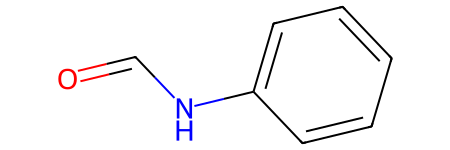

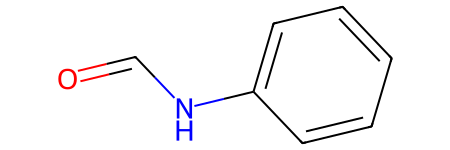

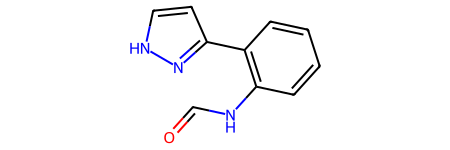

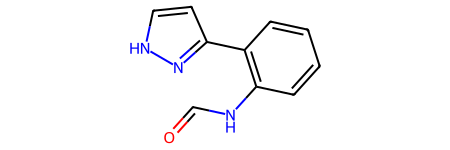

[12:59:10] Incomplete atom labelling, cannot make bond


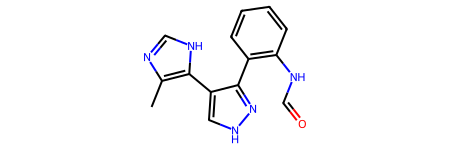

[12:59:10] Incomplete atom labelling, cannot make bond


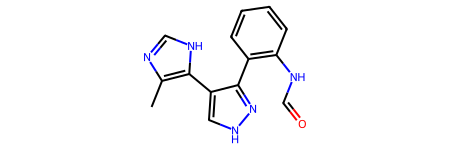

[12:59:10] Incomplete atom labelling, cannot make bond
[12:59:10] Incomplete atom labelling, cannot make bond


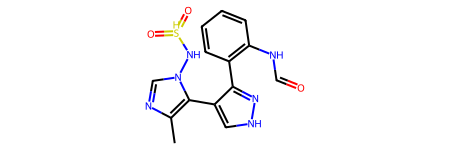

[12:59:10] Incomplete atom labelling, cannot make bond
[12:59:10] Incomplete atom labelling, cannot make bond


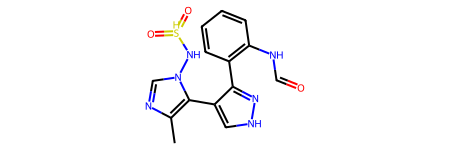

[12:59:10] Incomplete atom labelling, cannot make bond
[12:59:10] Incomplete atom labelling, cannot make bond
[12:59:10] Incomplete atom labelling, cannot make bond
[12:59:10] Incomplete atom labelling, cannot make bond


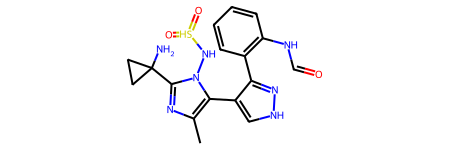

[12:59:10] Incomplete atom labelling, cannot make bond
[12:59:10] Incomplete atom labelling, cannot make bond
[12:59:10] Incomplete atom labelling, cannot make bond
[12:59:10] Incomplete atom labelling, cannot make bond


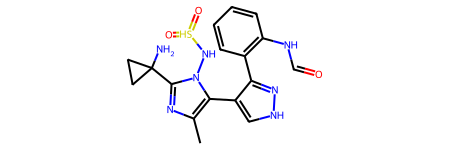

[12:59:11] Incomplete atom labelling, cannot make bond
[12:59:11] Incomplete atom labelling, cannot make bond
[12:59:11] Incomplete atom labelling, cannot make bond
[12:59:11] Incomplete atom labelling, cannot make bond
[12:59:11] Incomplete atom labelling, cannot make bond
[12:59:11] Incomplete atom labelling, cannot make bond
[12:59:11] Incomplete atom labelling, cannot make bond
[12:59:11] Incomplete atom labelling, cannot make bond
[12:59:11] Incomplete atom labelling, cannot make bond
[12:59:11] Incomplete atom labelling, cannot make bond


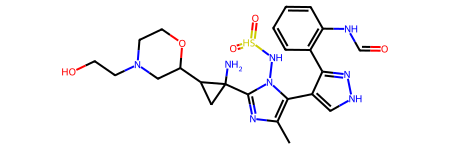

In [92]:
done = False
env.reset()
while not done:
    action = np.random.randint(len(env.action_space))
    state, reward, done, info = env.step(action)
    state_mol = env.get_gs_state()
    display(state_mol)
done = True

# These warnings occur when decoding particular actions from the action space

In [75]:
for i, a in enumerate(env.action_space):
    print(i, a)

0 [:0phenylmethanamine]
1 [:0morpholine4carbaldehyde]
2 [:0pyrazine]
3 [:0;4(trifluoromethyl)pyrimidine]
4 [:0hydrogen cyanide]
5 [:0benzofuran]
6 [:0;2(piperazin1yl)ethan1ol]
7 [:0propan1ol]
8 [:0ethane1,2diamine]
9 [:0N,Ndimethylacetamide]
10 [:0;1(4chlorophenyl)urea]
11 [:0;1chloro3methylbenzene]
12 [N][SH1][=Branch][=O][pop][=O]
13 [:0;3,4dimethyl1Hpyrazole5carboxylic acid]
14 [:0;3ethynylpyridine]
15 [:0cyclopropanamine]
16 [:0(trifluoromethoxy)benzene]
17 [:0;4phenylmorpholine]
18 [N][C][=Branch][=S][pop][:5aniline]
19 [:0benzamide]
20 [:0;4chlorobenzene1,2diol]
21 [C][SH1][=Branch][=O][pop][=O]
22 [:0propane]
23 [:0anisole]
24 [:0Nphenylformamide]
25 [:0(methylsulfonyl)benzene]
26 [:0N,Ndimethylethanamine]
27 [:0;2methoxypyridine]
28 [:0propionic acid]
29 [:0triethylamine]
30 [:0ethylbenzene]
31 [:0N,Ndimethyl1phenylmethanamine]
32 [:0;1methylpiperazine]
33 [:0;2Htetrazole]
34 [:0;1Hbenzo(d)imidazole5carboxamide]
35 [:0picolinamide]
36 [O][=NH0+1][OH0-1]
37 [:0;4fluorobenzaldehy

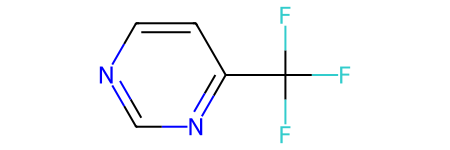

In [91]:
env.grammar.decoder(env.action_space[3])